<a href="https://colab.research.google.com/github/giovanni-lucarelli/distribution-shift/blob/main/GAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install pygam

In [2]:
import pandas as pd
from pygam import LinearGAM, s, te, f, LogisticGAM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score


In [3]:
# Load the training and testing datasets

df_train = pd.read_csv('https://raw.github.com/giovanni-lucarelli/distribution-shift/main/data/train.csv')
df_test_09 = pd.read_csv('https://raw.github.com/giovanni-lucarelli/distribution-shift/main/data/mix_0.9.csv')
df_test_07 = pd.read_csv('https://raw.github.com/giovanni-lucarelli/distribution-shift/main/data/mix_0.7.csv')
df_test_05 = pd.read_csv('https://raw.github.com/giovanni-lucarelli/distribution-shift/main/data/mix_0.5.csv')

# Binary Classification

## Test

In [4]:
for df_test in [df_test_09, df_test_07, df_test_05]:
  X_test = df_test[['X1', 'X2', 'X3']].values
  y_test = df_test['Y'].values


In [5]:
# Define features and target
X_train = df_train[['X1', 'X2', 'X3']]
y_train = df_train['Y']

In [9]:
from sklearn.model_selection import ParameterGrid

def LogGamTuning(X_train, y_train, X_test, y_test):
    # Define grid
    grid = ParameterGrid({
    'lam': [0.1, 10],
    'n_splines': [10],
    })

    best_model = None
    best_score = -np.inf

    # Iterate over the grid
    for params in grid:
        gam = LogisticGAM(
        s(0, n_splines=params['n_splines'], lam=params['lam']) +
        s(1, n_splines=params['n_splines'], lam=params['lam']) +
        s(2, n_splines=params['n_splines'], lam=params['lam']) +
        te(0, 1, n_splines=params['n_splines'], lam=params['lam']) +
        te(0, 2, n_splines=params['n_splines'], lam=params['lam']) +
        te(1, 2, n_splines=params['n_splines'], lam=params['lam'])
    )
    gam.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_pred = gam.predict(X_test)
    score = accuracy_score(y_test, val_pred)
    
    if score > best_score:
        best_score = score
        best_model = gam
    
    return best_model

Accuracy: 0.82
False Positive Rate (FPR): 0.16
False Negative Rate (FNR): 0.20
Area Under Curve (AUC): 0.90


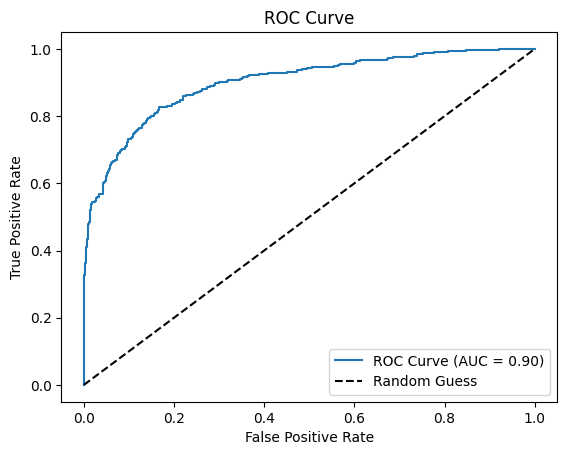

Accuracy: 0.74
False Positive Rate (FPR): 0.11
False Negative Rate (FNR): 0.47
Area Under Curve (AUC): 0.79


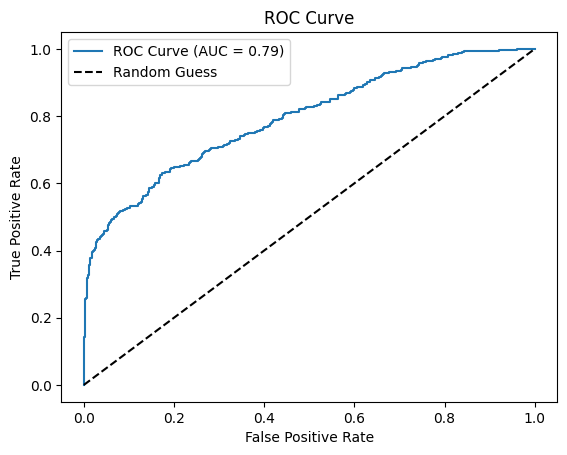

Accuracy: 0.70
False Positive Rate (FPR): 0.12
False Negative Rate (FNR): 0.58
Area Under Curve (AUC): 0.75


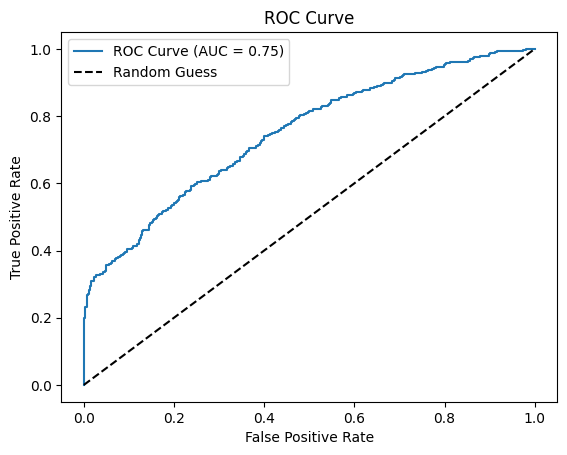

Accuracy: 0.73
False Positive Rate (FPR): 0.06
False Negative Rate (FNR): 0.74
Area Under Curve (AUC): 0.74


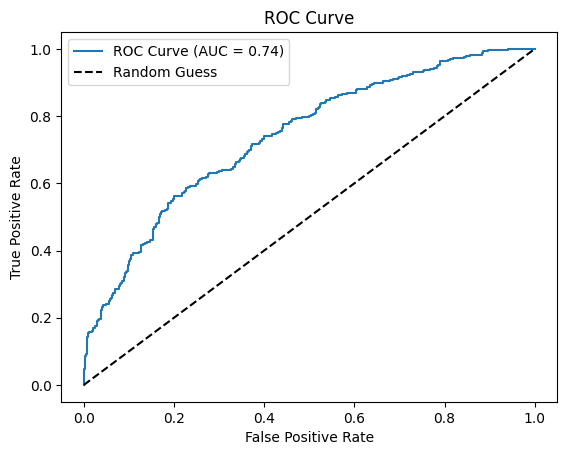

In [18]:
for df_test in [df_train, df_test_05, df_test_07, df_test_09]:

  X_test = df_test[['X1', 'X2', 'X3']]
  y_test = df_test['Y']


  gam = LogGamTuning(X_train, y_train, X_test, y_test)

  # Make predictions on the test dataset
  y_pred = gam.predict(X_test)
  y_prob = gam.predict_proba(X_test)
  # Generate the confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Display the confusion matrix
  # ConfusionMatrixDisplay(confusion_matrix=cm).plot()
  # plt.title('Confusion Matrix')
  # plt.show()

  # Calculate accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print(f'Accuracy: {accuracy:.2f}')

  # Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
  fp = cm[0][1]
  fn = cm[1][0]
  tn = cm[0][0]
  tp = cm[1][1]

  fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
  fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

  print(f'False Positive Rate (FPR): {fpr:.2f}')
  print(f'False Negative Rate (FNR): {fnr:.2f}')

  # Calculate ROC curve and AUC
  fpr_values, tpr_values, thresholds = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr_values, tpr_values)

  print(f'Area Under Curve (AUC): {roc_auc:.2f}')

  # Plot ROC curve
  plt.figure()
  plt.plot(fpr_values, tpr_values, label=f'ROC Curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()


  